In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from IPython.display import clear_output
import time
import os

c:\Users\Usuario\.conda\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Usuario\.conda\envs\torch\lib\site-packages\torch\cuda\__init__.py:83: UserWarning: CUDA initialization: CUDA driver initialization failed, you might not have a CUDA gpu. (Triggered internally at  C:\cb\pytorch_1000000000000\work\c10\cuda\CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


# Starting

* To generate synthetic data, a set of points is generated linearly spaced.
* The points represent measurement with one unique feature. Therefore, the vector is reshaped as a column where each row is an instance with a unique feature
* It is added some noise
* The output true values are calculated
* The goal will be to get back, the slope (weight) and constant (bias) by using a linear neuron

In [2]:
torch.manual_seed(41)
X = torch.linspace(0,50,50,dtype= torch.float).reshape(-1,1)
noise = torch.randint(-10,10,(50,1))
fY = lambda x: 4*x[0]+ 5 +x[1]
functionIn = np.concatenate((X.numpy(), noise.numpy()),axis = 1)
Ytrue = np.array([fY(pair) for pair in functionIn])


* Visualize data

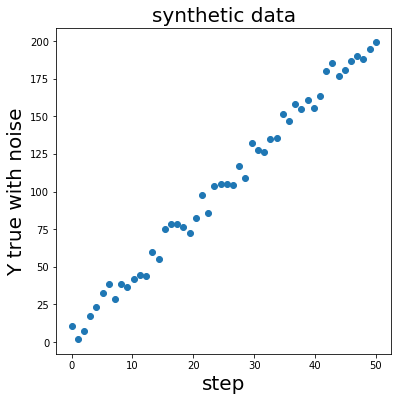

In [3]:
plt.figure(figsize=(6,6))
plt.scatter(X.numpy(), Ytrue)
plt.title('synthetic data', size = 20)
plt.xlabel('step', size = 20)
plt.ylabel('Y true with noise', size = 20)
plt.show()

## Linear neuron class

* A class is created to produce the model, and the class inherit from nn.Module.
* It is instantiated the forward pass through the “network”

In [4]:
class LinearNeuron(nn.Module):
    def __init__(self,in_features,out_features):
        super().__init__()
        self.linear = nn.Linear(in_features,out_features)

    def forwardPropagation(self,data):
        ypredict = self.linear(data)
        return ypredict

### Stochastic Gradient Descent quick notes

* **Gradient Descent:** It is the most basic but most used optimization algorithm. It’s used heavily in linear regression and classification algorithms. Backpropagation in neural networks also uses a gradient descent algorithm. Gradient descent is a first-order optimization algorithm which is dependent on the first order derivative of a loss function.
* **Stochastic Gradient Descent (SGD):** It’s a variant of Gradient Descent. It tries to update the model’s parameters more frequently. In this, the model parameters are altered after computation of loss on each training example. So, if the dataset contains 1000 rows SGD will update the model parameters 1000 times in one cycle of dataset instead of one time as in Gradient Descent.
    * Advantages:
        * Frequent updates of model parameters hence, converges in less time.
        * Requires less memory as no need to store values of loss functions.
        * May get new minima’s.
    * Disadvantages:
        * High variance in model parameters.
        * May shoot even after achieving global minima.
        * To get the same convergence as gradient descent needs to slowly reduce the value of learning rate.

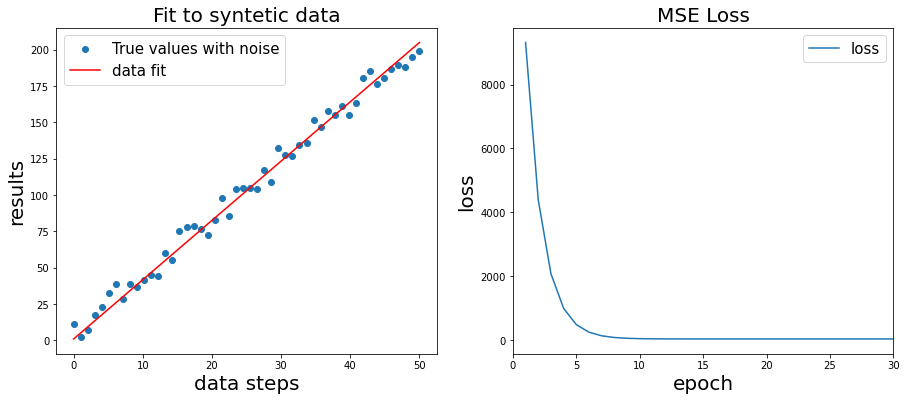

In [5]:
torch.manual_seed(42)
linearNeuronModel = LinearNeuron(1,1) #I instantiate the model
criterion = nn.MSELoss()    #  I need a way to measure the error. In this case, since the data is continuous, a the mean square error is an option
optimizer = torch.optim.SGD(linearNeuronModel.parameters(),lr=0.001) # The way we update weights
epochs = 30

YtrueTorch = torch.tensor(Ytrue, dtype = torch.float).reshape(-1,1)
listLosses = []
epochList = []
for epoch in range(epochs):
    optimizer.zero_grad() # We need that the tensor optimizer not accumulate gradients each cycle
    epochList.append(epoch+1)
    ypredict = linearNeuronModel.forwardPropagation(X) # passing the data 
    loss = criterion(ypredict,YtrueTorch)# calculating the loss
    listLosses.append(loss.item())
    weight = linearNeuronModel.linear.weight.item()
    bias = linearNeuronModel.linear.bias.item()
    loss.backward()# I perform backpropagation
    optimizer.step()# This step update the weights

    # The plots display a “movie” of the weight updates
    plt.figure(figsize=(15,6))
    plt.subplot(1,2,1)
    plt.scatter(X.numpy(), Ytrue, label = 'True values with noise')
    fNow = lambda x: weight*x + bias
    Ynow = np.array([fNow(x) for x in X.numpy()])
    plt.plot(X.numpy(), Ynow, color = 'red', label ='data fit')
    plt.title('Fit to syntetic data',size = 20)
    plt.xlabel('data steps', size = 20)
    plt.ylabel('results', size = 20)
    plt.legend(fontsize = 15)

    plt.subplot(1,2,2)
    plt.plot(epochList,listLosses, label = 'loss')
    plt.xlim([0,epochs])
    plt.title('MSE Loss',size = 20)
    plt.xlabel('epoch', size = 20)
    plt.ylabel('loss', size = 20)
    plt.legend(fontsize = 15)
    plt.show()
    time.sleep(0.5)
    clear_output(wait=True)

# Working with datsets

In [6]:
dfIris = pd.read_csv('iris.csv')
dfIris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


* Visulize the data

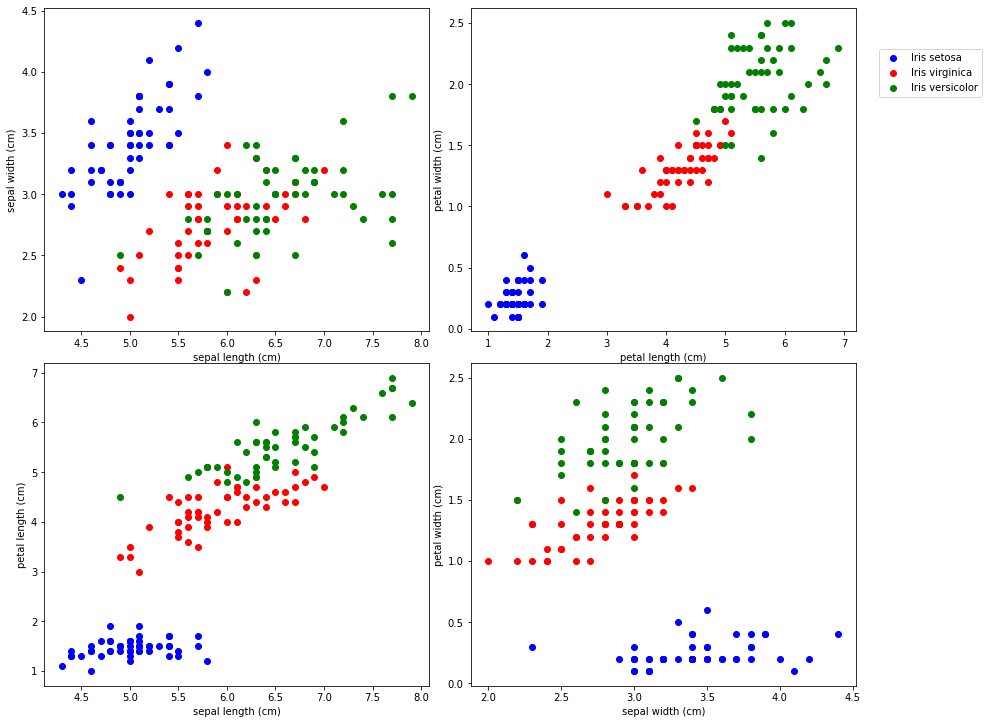

In [7]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize =(12,10))
fig.tight_layout()
plots = [(0,1),(2,3),(0,2),(1,3)]
colors = ['b', 'r', 'g']
labels = ['Iris setosa','Iris virginica','Iris versicolor']

for i, ax in enumerate(axes.flat):
    for j in range(3):
        x = dfIris.columns[plots[i][0]]
        y = dfIris.columns[plots[i][1]]
        ax.scatter(dfIris[dfIris['target']==j][x], dfIris[dfIris['target']==j][y], color=colors[j])
        ax.set(xlabel=x, ylabel=y)

fig.legend(labels=labels, loc=3, bbox_to_anchor=(1.0,0.85))
plt.show()

## Data needs train test split

In [8]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

In [9]:
data = dfIris.drop('target', axis = 1).values
labels = dfIris['target'].values

In [10]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size = 0.2, random_state =33)
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

# ANN

* Classifier with two hidden layers

In [11]:
class Model(nn.Module):
    def __init__(self,in_features = 4, h1 = 8, h2 = 9, out_features = 3):
        #how many layers
        #Input layer (4 features)-> 1 hiden N-Neurons -> 2 hiden N-Neurons -> output(3)
        super().__init__()
        self.fc1 = nn.Linear(in_features,h1)# First hidden
        self.fc2 = nn.Linear(h1,h2)# Second hidden
        self.out = nn.Linear(h2,out_features)# outPut

    def forward(self,x):
        a1 = F.relu(self.fc1(x))
        a2 = F.relu(self.fc2(a1))
        ypred = self.out(a2)
        return ypred


In [12]:
torch.manual_seed(32)
model = Model()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
epochs = 500
losses = []

for epoch in range(epochs):

    ypred = model.forward(X_train)
    loss = criterion(ypred,y_train)
    losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch%10==0:
        print(f"epoch: {epoch+1} loss: {loss}")



epoch: 1 loss: 1.1507114171981812
epoch: 11 loss: 0.9377315640449524
epoch: 21 loss: 0.7798256278038025
epoch: 31 loss: 0.6099401712417603
epoch: 41 loss: 0.40079936385154724
epoch: 51 loss: 0.2543632686138153
epoch: 61 loss: 0.15053054690361023
epoch: 71 loss: 0.10086946934461594
epoch: 81 loss: 0.08128315955400467
epoch: 91 loss: 0.07231428474187851
epoch: 101 loss: 0.067133329808712
epoch: 111 loss: 0.06355972588062286
epoch: 121 loss: 0.06085379794239998
epoch: 131 loss: 0.05870986729860306
epoch: 141 loss: 0.056958459317684174
epoch: 151 loss: 0.055492326617240906
epoch: 161 loss: 0.0542379654943943
epoch: 171 loss: 0.053144682198762894
epoch: 181 loss: 0.05217756703495979
epoch: 191 loss: 0.05131227523088455
epoch: 201 loss: 0.05053144320845604
epoch: 211 loss: 0.04982186108827591
epoch: 221 loss: 0.04917300119996071
epoch: 231 loss: 0.04857643321156502
epoch: 241 loss: 0.048025213181972504
epoch: 251 loss: 0.04751361533999443
epoch: 261 loss: 0.04703695327043533
epoch: 271 loss:

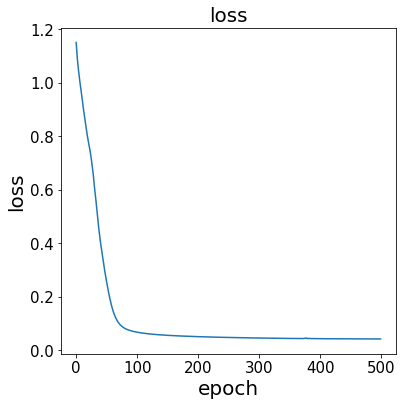

In [13]:
plt.figure(figsize=(6,6))
plt.plot(range(epochs), losses)
plt.title('loss',size = 20)
plt.xlabel('epoch', size = 20)
plt.ylabel('loss', size = 20)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.show()

* Predictions on the test set without changing the weights and biases from the model

In [16]:
with torch.no_grad():
    yval = model.forward(X_test)
    loss = criterion(yval,y_test)

In [17]:
loss

tensor(0.0473)

In [ ]:
correct = 0
with torch.no_grad():
    for i, data in enumerate(X_test):
        y_val = model.forward(data)
        print(f"{i+1} {y_val.argmax().item()} {y_test[i]}")

        if y_val.argmax().item() == y_test[i]:
            correct +=1

In [24]:
correct

30

* Saving the model

In [25]:
torch.save(model.state_dict(),'fully_connected_Iris.pt')

* Predictions on a singular point

In [27]:
myNewFlower = torch.tensor([5.6,3.7,2.2,0.5], dtype=torch.float)

In [29]:
with torch.no_grad():
    ypred = newModel(myNewFlower)
    print(ypred.argmax().item())

0


# More realistic dataset than Iris dataset

* I am using NYC taxi driver fair dataset from Kaggel.
* It contains continuous data and categorical data.
* The data requires some data engineering before passing data through the network.
* The goal is to predict how much the taxi driver will charge for a particular ride.
* Overall is a more “realistic” dataset than the iris dataset.


In [54]:
from geopy import distance

In [32]:
df = pd.read_csv('NYCTaxiFares.csv')
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


## Data overview

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   pickup_datetime    120000 non-null  object 
 1   fare_amount        120000 non-null  float64
 2   fare_class         120000 non-null  int64  
 3   pickup_longitude   120000 non-null  float64
 4   pickup_latitude    120000 non-null  float64
 5   dropoff_longitude  120000 non-null  float64
 6   dropoff_latitude   120000 non-null  float64
 7   passenger_count    120000 non-null  int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 7.3+ MB


In [33]:
df.describe()

,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000
mean,10.040326,0.333333,-73.976626,40.751443,-73.974501,40.751695,1.347167
std,7.500134,0.471406,0.031497,0.025821,0.032419,0.030279,0.759263
min,2.500000,0.000000,-74.465447,40.121653,-74.443323,40.164927,1.000000
25%,5.700000,0.000000,-73.992386,40.736594,-73.991478,40.735914,1.000000
50%,7.700000,0.000000,-73.982084,40.753661,-73.980411,40.754441,1.000000
75%,11.300000,1.000000,-73.968710,40.768020,-73.965500,40.768880,1.000000
max,49.900000,1.000000,-73.311845,40.981292,-73.496140,40.993498,5.000000


In [48]:
df.isnull().sum().sum()

0

In [49]:
df.isna().sum().sum()

0

## Feature engineering

* One can expect a poor performance of a neural network when a short train is performed on raw GPS data coming from the same city. This is because GPS data from the same city will be different only at the last decimal points.
* The GPS data is transformed on distances between pickup and drop point.
* The column distance is created

In [56]:
df['distance'] = df.apply(lambda x: distance.distance((x['pickup_longitude'],x['pickup_latitude']),(x['dropoff_longitude'],x['dropoff_latitude'])).km, axis = 1)
df['distance'].describe()

count    120000.000000
mean          2.652620
std           3.472919
min           0.003143
25%           0.901845
50%           1.610695
75%           2.892851
max          31.642037
Name: distance, dtype: float64

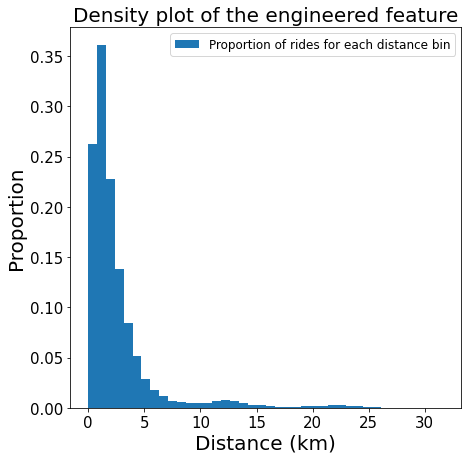

In [65]:
plt.figure(figsize = (7,7))
plt.hist(df['distance'], bins= 40, density = True, label = 'Proportion of rides for each distance bin')
plt.title('Density plot of the engineered feature', size = 20)
plt.xlabel('Distance (km)', size =20)
plt.ylabel('Proportion', size = 20)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.legend(fontsize = 12)
plt.show()

* It is necessary to transform the date data into a format and features that a neural network can understand

In [66]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   pickup_datetime    120000 non-null  datetime64[ns, UTC]
 1   fare_amount        120000 non-null  float64            
 2   fare_class         120000 non-null  int64              
 3   pickup_longitude   120000 non-null  float64            
 4   pickup_latitude    120000 non-null  float64            
 5   dropoff_longitude  120000 non-null  float64            
 6   dropoff_latitude   120000 non-null  float64            
 7   passenger_count    120000 non-null  int64              
 8   distance           120000 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(6), int64(2)
memory usage: 8.2 MB


### Date technicality

* Our date time is in UTC but the data was taken in NYC in April 2010, which means that the time zone is EDT. and the date is taken during daylight saving time.
* There will be a difference of 4 hours with respect to our data.

In [68]:
df['EDT']=df['pickup_datetime']-pd.Timedelta(4)

## Taking potentially interesting attributes from dates

In [70]:
df['hour'] = df['EDT'].dt.hour
df['AM/PM'] = np.where(df['hour']<12,'AM','PM')
df['day'] = df['EDT'].dt.strftime('%a')

In [71]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,EDT,hour,AM/PM,day
0,2010-04-19 08:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,1.932727,2010-04-19 08:17:55.999999996+00:00,8,AM,Mon
1,2010-04-17 15:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.771932,2010-04-17 15:43:52.999999996+00:00,15,PM,Sat
2,2010-04-17 11:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.832587,2010-04-17 11:23:25.999999996+00:00,11,AM,Sat
3,2010-04-11 21:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,2.166696,2010-04-11 21:25:02.999999996+00:00,21,PM,Sun
4,2010-04-17 02:19:01+00:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,9.492877,2010-04-17 02:19:00.999999996+00:00,2,AM,Sat


### Brief data exploration

In [90]:
dfC = df.groupby(['day']).agg({'distance':[np.mean,np.std],'day':'count'})
dfC

distance              day
         mean       std  count
day                           
Fri  2.609379  3.426566  18631
Mon  2.734421  3.641302  15426
Sat  2.510320  3.142275  17928
Sun  2.858496  3.675732  15868
Thu  2.680287  3.531687  17914
Tue  2.599285  3.418400  16995
Wed  2.608466  3.485431  17238

<AxesSubplot:xlabel='day'>

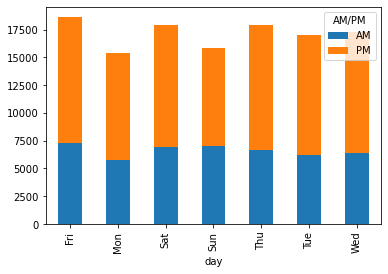

In [126]:
dfC = df.groupby(['day', 'AM/PM']).size().to_frame('counts').reset_index()
pd.pivot_table(dfC, values = 'counts', index = 'day', columns = 'AM/PM').plot(kind="bar", stacked=True)


* The mean value of the rides is similar and about 2.6 Km for all cases.
* On Sundays, the mean distance is slightly higher.
* There are more taxi rides at PM times.


## Dealing with categorical variables

I separate the categorical, continous variables and target to predict

In [145]:
cat = ['fare_class','hour','AM/PM','day']
cont = ['pickup_longitude','pickup_latitude', 'dropoff_longitude', 'dropoff_latitude','passenger_count', 'distance']
target = ['fare_amount']

In [133]:
df[cat]=df[cat].astype('category')

## Preparing data to be transformed in a tensor

* The codes of each category for each instance are transformed in a numpy array
* The arrays are stacked as columns

In [139]:
fare = df['fare_class'].cat.codes.values
hour = df['hour'].cat.codes.values
ampm = df['AM/PM'].cat.codes.values
day = df['day'].cat.codes.values

cate = np.stack([fare,hour,ampm,day], axis = 1)
cate = torch.tensor(cate, dtype = torch.int64)
cate

tensor([[ 0,  8,  0,  1],
        [ 0, 15,  1,  2],
        [ 1, 11,  0,  2],
        ...,
        [ 1, 18,  1,  3],
        [ 0,  8,  0,  5],
        [ 0, 16,  1,  2]])

In [143]:
conts = torch.tensor(df[cont].values, dtype = torch.float)
conts

tensor([[-73.9924,  40.7305, -73.9755,  40.7447,   1.0000,   1.9327],
        [-73.9901,  40.7406, -73.9742,  40.7441,   1.0000,   1.7719],
        [-73.9941,  40.7511, -73.9601,  40.7662,   2.0000,   3.8326],
        ...,
        [-73.9886,  40.7498, -74.0115,  40.7078,   3.0000,   2.8705],
        [-74.0044,  40.7245, -73.9927,  40.7308,   1.0000,   1.3256],
        [-73.9554,  40.7719, -73.9676,  40.7630,   3.0000,   1.3899]])

In [146]:
targets = torch.tensor(df[target[0]].values, dtype = torch.float).reshape(-1,1)
targets

tensor([[ 6.5000],
        [ 6.9000],
        [10.1000],
        ...,
        [12.5000],
        [ 4.9000],
        [ 5.3000]])

* It is required to keep track of the size of the categories

In [148]:
cate_size = [len(df[c].cat.categories) for c in cat]
cate_size

[2, 24, 2, 7]

* I use embeddings from torch to perform one-hot encoding.
* The maximum size for the embeddings has to be fixed

### torch.nn.Embedding quick notes

* It has two required arguments: m_embeddings, embedding_dim.
* m_embeddings: It represents the size of the dictionary present in the embeddings, and it is represented in integers.
* embedding_dim: It represents the size of each vector present in the embeddings, which is represented in integers.
* In one-hot encoding, the encoding will result in a vector whose dimensions are the same as the number of categories or n-1 dimensions.
* In nn.Embedding we will get a set of dictionaries where each class is encoded in vector as long as embedding_dim.
* m_embeddings: It is used to give the total number of classes that we have.
* This is useful because:
    * In contrast with one-hot encoding, we will end up having fewer features to encode the same information (lower dimensions)
    * The encoding is a continuous set of values
    * The two mentioned reasons  lead to a more efficient NN training


### torchnn.BatchNorm1d quick notes

* It has one required argument -> the number of features
* What it does: It consists of normalizing activation vectors from hidden layers using the first and the second statistical moments (mean and variance) of the current batch. This normalization step is applied right before (or right after) the nonlinear function.
* Why we do it?: [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/abs/1502.03167)

### Dropout quick notes

* It is a regularization method which de activate neurons with a certain probability. 
* It helps to avoid overfitting. 
* It can be seen as training in parallel NN.

In [154]:
emb_size = [(size, min(50, (size+1)//2)) for size in cate_size]
emb_size

[(2, 1), (24, 12), (2, 1), (7, 4)]

* Aproximation 1

In [170]:
class TabularData(nn.Module):
    def __init__(self,numCat_numDimEconding_Pair,num_continuousFeatures,outputSize, listOfNeuronsOfEachLayer, dropOutProb=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni,nf) for ni, nf in numCat_numDimEconding_Pair]) # returns a "list"
        self.dropOut = nn.Dropout(dropOutProb) # deactivate neurons with certain probability
        self.normCont = nn.BatchNorm1d(num_continuousFeatures)

        layerList = []
        totalEmbedSize = sum([ x[1] for x in numCat_numDimEconding_Pair])#We only care about the second number because it gives us the number of features added to encode the categories of each class
        n_in = totalEmbedSize + num_continuousFeatures # Our real number of features after encoding the categorical variables
        for i in listOfNeuronsOfEachLayer:
            layerList.append(nn.Linear(n_in,i))
            layerList.append(nn.ReLU(inplace = True))
            layerList.append(nn.BatchNorm1d(i))
            layerList.append(nn.Dropout(dropOutProb))
            n_in = i # for the next layer the features IN will be the features OUT from the former layer

        layerList.append(nn.Linear(listOfNeuronsOfEachLayer[-1],outputSize))
        self.layers = nn.Sequential(*layerList)

    def forward(self,categoricalData,continuous):
        emb = []

# we go through the "list" of embeddings that we define at initialization
# Each of the embeddings will encode a categorical variable
# We need to pass all the rows for the column containing each categorical variable by its encoder.
# Because how we have structured our categorical data in the data tensor n of the encoder matches with n of its categorical data associated

        for n, encoder in enumerate(self.embeds):
            emb.append(encoder(categoricalData[:,n])) 
        
        x = torch.cat(emb,1) # The categorical data from the list is concatenated
        x = self.dropOut(x)
        x_cont = self.normCont(continuous) # batch normalization before passing the data
        x = torch.cat([x,x_cont],1) # Concatenate along column axis (categorical and continuous data)
        ypred = self.layers(x)
        return ypred

* Aproximation 2

In [270]:
class TabularData2(nn.Module):
    def __init__(self,numCat_numDimEconding_Pair,num_continuousFeatures, listOfNeuronsOfEachLayer,outPutSize, dropOutProb=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni,nf) for ni, nf in numCat_numDimEconding_Pair]) # returns a "list"
        self.dropOut = nn.Dropout(dropOutProb) # deactivate neurons with certain probability
        self.normCont = nn.BatchNorm1d(num_continuousFeatures)


        layerList = []
        totalEmbedSize = sum([ x[1] for x in numCat_numDimEconding_Pair])#We only care about the second number because it gives us the number of features added to encode the categories of each class
        n_in = totalEmbedSize + num_continuousFeatures # Our real number of features after encoding the categorical variables
        for i in listOfNeuronsOfEachLayer:
            layerList.append(nn.Linear(n_in,i))
            layerList.append(nn.ReLU(inplace = True))
            layerList.append(nn.BatchNorm1d(i))
            layerList.append(nn.Dropout(dropOutProb))
            n_in = i # for the next layer the features IN will be the features OUT from the former layer

        layerList.append(nn.Linear(listOfNeuronsOfEachLayer[-1],outPutSize))
        self.layers = nn.Sequential(*layerList)

    def prepareData(self, categoricalData, continuousData):

    # we go through the "list" of embeddings that we define at initialization
    # Each of the embeddings will encode a categorical variable
    # We need to pass all the rows for the column containing each categorical variable by its encoder.
    # Because how we have structured our categorical data in the data tensor n of the encoder matches with n of its categorical data associated
        emb = []
        for n, encoder in enumerate(self.embeds):
            emb.append(encoder(categoricalData[:,n]))
        x = torch.cat(emb,1) # The categorical data from the list is concatenated
        x_cont = self.normCont(continuousData) # batch normalization before passing the data
        dataNN = torch.cat([x,x_cont],1) # Concatenate along column axis (categorical and continuous data)
        return dataNN
    def forward(self,dataNN):
        ypred = self.layers(dataNN) # Passing the data
        return ypred

In [206]:
# The data has been shuffled

batchSize = conts.shape[0]
testSize = int(batchSize*0.2)

catTrain = cate[:batchSize-testSize]
catTest = cate[batchSize-testSize:batchSize]
contTrain = conts[:batchSize-testSize]
contTest = conts[batchSize-testSize:batchSize]
yTrain = targets[:batchSize-testSize]
yTest = targets[batchSize-testSize:batchSize]

In [183]:
from tqdm import trange
import time

In [220]:
torch.manual_seed(33)
model = TabularData(emb_size,len(cont),1,[200,100],0.4)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
epochs = 500
losses = []
startTime = time.time()

with trange(epochs, unit="epoch") as pbar:
    for epoch in pbar:
        ypred = model.forward(catTrain,contTrain)
        loss = criterion(ypred,yTrain)
        losses.append(np.sqrt(loss.item()))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pbar.set_postfix(loss=loss.item())
finalTime = time.time()
totalTime = finalTime - startTime
print(f"Total time: {totalTime/60} minutes")


100%|██████████| 500/500 [06:00<00:00,  1.39epoch/s, loss=10.5]

Total time: 6.004225103060405 minutes


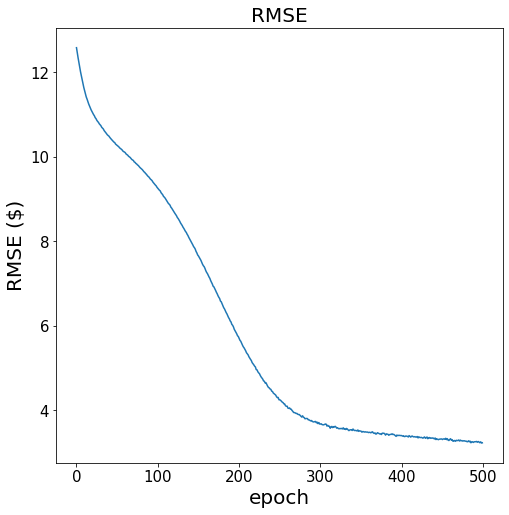

In [221]:
plt.figure(figsize=(8,8))
plt.plot(range(epochs),losses)
plt.title('RMSE', size = 20)
plt.xlabel('epoch', size = 20)
plt.ylabel('RMSE ($)', size = 20)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.show()

In [224]:
with torch.no_grad():
    ypredTest = model(catTest,contTest)
    loss = criterion(ypredTest,yTest)
loss = np.sqrt(loss.item()) 
print(loss)   

3.238338824267664


In [228]:
torch.save(model.state_dict(),'taxiFair.pt')

In [276]:
torch.manual_seed(33)
model2 = TabularData2(emb_size,len(cont),[200,100],1,0.4)
dataNN = model2.prepareData(catTrain,contTrain)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model2.parameters(), lr = 0.001)
epochs = 500
losses = []
startTime = time.time()

with trange(epochs, unit="epoch") as pbar:
    for epoch in pbar:
        ypred_ = model2.forward(dataNN)
        loss = criterion(ypred_,yTrain)
        losses.append(np.sqrt(loss.item()))
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        pbar.set_postfix(loss=loss.item())
finalTime = time.time()
totalTime = finalTime - startTime
print(f"Total time: {totalTime/60} minutes")

100%|██████████| 500/500 [05:20<00:00,  1.56epoch/s, loss=12.5]

Total time: 5.345766075452169 minutes


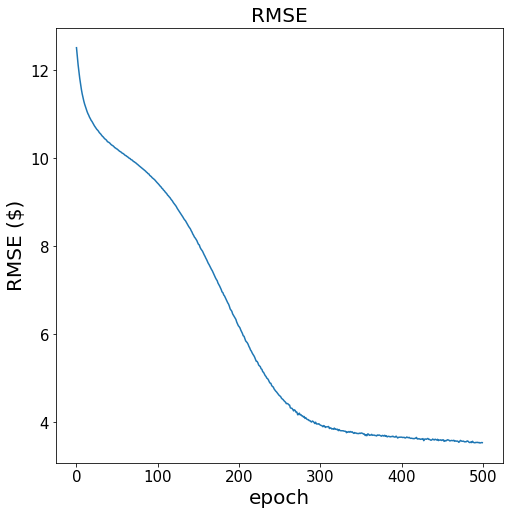

In [277]:
plt.figure(figsize=(8,8))
plt.plot(range(epochs),losses)
plt.title('RMSE', size = 20)
plt.xlabel('epoch', size = 20)
plt.ylabel('RMSE ($)', size = 20)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.show()

In [279]:
with torch.no_grad():
    dataNNT = model2.prepareData(catTest,contTest)
    ypredTest = model2(dataNNT)
    loss = criterion(ypredTest,yTest)
loss = np.sqrt(loss.item()) 
print(loss)   

3.4999925068366355


## Same code for classification problem

*  Now I will use a [dataset](https://archive.ics.uci.edu/ml/datasets/Census+Income) for a binary classification problem where we have to predict whether the income is above or below 50k

In [288]:
header =['age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship','race','sex','capital-gain','capital-loss','hours-per-week','native-country','income']
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data',names = header)
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


* The goal is to make a binary prediction and not to get any inside from the data.
* Only data cleaning is performed

### Data exploration

In [289]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [290]:
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


#### Exploring text features

* For all the classes, individually, we explore unique values and counts to find miss spellings or some Na value.
* Instead of NA values, I found some records described as ‘?’

In [324]:
df['income'].unique()

array([' <=50K', ' >50K'], dtype=object)

In [325]:
df['income'].value_counts()

 <=50K    24720
 >50K      7841
Name: income, dtype: int64

In [327]:
textCols = ['workclass','education','marital-status','occupation','relationship','race','sex','native-country','income']

In [329]:
df[textCols] = df.apply(lambda x: [i.strip().lower() for i in x[textCols].values.tolist()], axis = 1, result_type= 'expand')

In [330]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,state-gov,77516,bachelors,13,never-married,adm-clerical,not-in-family,white,male,2174,0,40,united-states,<=50k
1,50,self-emp-not-inc,83311,bachelors,13,married-civ-spouse,exec-managerial,husband,white,male,0,0,13,united-states,<=50k
2,38,private,215646,hs-grad,9,divorced,handlers-cleaners,not-in-family,white,male,0,0,40,united-states,<=50k
3,53,private,234721,11th,7,married-civ-spouse,handlers-cleaners,husband,black,male,0,0,40,united-states,<=50k
4,28,private,338409,bachelors,13,married-civ-spouse,prof-specialty,wife,black,female,0,0,40,cuba,<=50k


In [333]:
df1 = df.copy(deep = True)

* The unknown values are removed

In [338]:
for col in textCols:
    df1 = df1[df1[col] != '?']

In [339]:
print(f"We are keeping {len(df1)*100/len(df):8.2f}% of the records")

We are keeping    92.63% of the records


#### Exploring continuous features

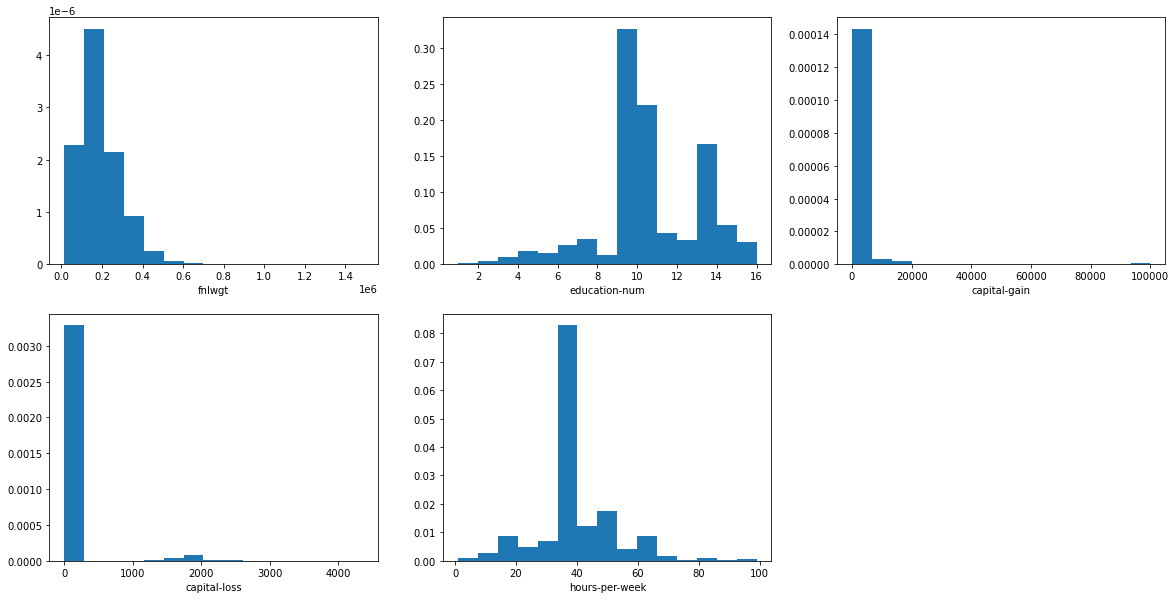

In [347]:
contCols = ['fnlwgt','education-num','capital-gain','capital-loss','hours-per-week']
plt.figure(figsize = (20,10))
for n, col in enumerate(contCols):
    plt.subplot(2,3,n+1)
    plt.hist(df1[col], bins=15, density = True)
    plt.xlabel(col)
plt.show()

In [352]:
valscg = len(df1[df1['capital-gain']==0])/len(df1)
valscl = len(df1[df1['capital-loss']==0])/len(df1)

print(f"The column capital-gain is equal to zero in {valscg*100:8.2f}% of the cases")
print(f"The column capital-loss is equal to zero in {valscl*100:8.2f}% of the cases")
print('I will not consider the columns capital gain and capital loss')
print('I will not consider the column education, the information is encoded in the column education-num')

The column capital-gain is equal to zero in    91.59% of the cases
The column capital-loss is equal to zero in    95.27% of the cases
I will not consider the columns capital gain and capital loss
I will not consider the column education, the information is encoded in the column education-num


In [353]:
df1 = df1[['age','workclass','fnlwgt','education-num','marital-status','occupation','relationship','race','sex','hours-per-week','native-country','income']]
df1.head()

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,income
0,39,state-gov,77516,13,never-married,adm-clerical,not-in-family,white,male,40,united-states,<=50k
1,50,self-emp-not-inc,83311,13,married-civ-spouse,exec-managerial,husband,white,male,13,united-states,<=50k
2,38,private,215646,9,divorced,handlers-cleaners,not-in-family,white,male,40,united-states,<=50k
3,53,private,234721,7,married-civ-spouse,handlers-cleaners,husband,black,male,40,united-states,<=50k
4,28,private,338409,13,married-civ-spouse,prof-specialty,wife,black,female,40,cuba,<=50k


* Transforming to categorical columns

In [354]:
catecols = ['workclass','education-num','marital-status','occupation','relationship','race','sex','native-country','income']
contcols = ['age','fnlwgt','hours-per-week']
df1[catecols] = df1[catecols].astype('category')
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30162 entries, 0 to 32560
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             30162 non-null  int64   
 1   workclass       30162 non-null  category
 2   fnlwgt          30162 non-null  int64   
 3   education-num   30162 non-null  category
 4   marital-status  30162 non-null  category
 5   occupation      30162 non-null  category
 6   relationship    30162 non-null  category
 7   race            30162 non-null  category
 8   sex             30162 non-null  category
 9   hours-per-week  30162 non-null  int64   
 10  native-country  30162 non-null  category
 11  income          30162 non-null  category
dtypes: category(9), int64(3)
memory usage: 1.2 MB


* Transforming to tensors

In [357]:
catecolsNotarget = ['workclass','education-num','marital-status','occupation','relationship','race','sex','native-country']
cateDataArray = np.stack([df1[col].cat.codes.values for col in catecolsNotarget], axis = 1)
catDataTensor = torch.tensor(cateDataArray, dtype = torch.int64)
catDataTensor

tensor([[ 5, 12,  4,  ...,  4,  1, 38],
        [ 4, 12,  2,  ...,  4,  1, 38],
        [ 2,  8,  0,  ...,  4,  1, 38],
        ...,
        [ 2,  8,  6,  ...,  4,  0, 38],
        [ 2,  8,  4,  ...,  4,  1, 38],
        [ 3,  8,  2,  ...,  4,  0, 38]])

In [358]:
contDataTensor = torch.tensor(df1[contcols].values, dtype = torch.int64)
contDataTensor

tensor([[    39,  77516,     40],
        [    50,  83311,     13],
        [    38, 215646,     40],
        ...,
        [    58, 151910,     40],
        [    22, 201490,     20],
        [    52, 287927,     40]])

In [365]:
targetTensor = torch.tensor(np.array([0 if '<' in target else 1 for target in df1['income'].values.tolist()]), dtype = torch.int64).reshape(-1,1)
targetTensor

tensor([[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [1]])

#### Train Test split

In [385]:
DataIn = torch.cat([contDataTensor,catDataTensor], 1).numpy()
targetnp = targetTensor.numpy()
XTrain, XTest, yTrain, yTest = train_test_split(DataIn,targetnp,test_size=0.2, stratify = targetnp, random_state = 41)

In [423]:
contXTrainTensor = torch.tensor(XTrain[:,:3], dtype = torch.float)
cateXTrainTensor = torch.tensor(XTrain[:,3:], dtype = torch.int64)
contXTestTensor = torch.tensor(XTest[:,:3], dtype = torch.float)
cateXTestTensor = torch.tensor(XTest[:,3:], dtype = torch.int64)
yTrainTensor = torch.tensor(yTrain, dtype = torch.int64).flatten()
yTestTensor = torch.tensor(yTest, dtype = torch.int64).flatten()


#### Embeddings pairs

In [368]:
embPairs = [(len(df1[col].unique()), min(50, len(df1[col].unique())//2)) for col in catecolsNotarget]
embPairs

[(7, 3), (16, 8), (7, 3), (14, 7), (6, 3), (5, 2), (2, 1), (41, 20)]

In [405]:
class ModelIncome(nn.Module):
    def __init__(self, numContFeatures,listOfLayers,outFeatures,embPairs, prob = 0.5):
        super().__init__()
        numFeatures = sum([p[1] for p in embPairs])+numContFeatures
        listOfLayersNN = []
        for neurons in listOfLayers:
            listOfLayersNN.append(nn.Linear(numFeatures,neurons))
            listOfLayersNN.append(nn.ReLU(inplace = True))
            listOfLayersNN.append(nn.BatchNorm1d(neurons))
            listOfLayersNN.append(nn.Dropout(prob))
            numFeatures = neurons
        listOfLayersNN.append(nn.Linear(listOfLayers[-1],outFeatures))
        self.layers = nn.Sequential(*listOfLayersNN)
        self.embd = nn.ModuleList([nn.Embedding(pair[0],pair[1]) for pair in embPairs])
        self.bNorm = nn.BatchNorm1d(numContFeatures)
    def forward(self,categorical, continuous):
        emFeat = [encoder(categorical[:,n]) for n, encoder in enumerate(self.embd)]
        x = torch.cat(emFeat, dim = 1)
        xCount = self.bNorm(continuous)
        x = torch.cat([x,xCount], dim = 1)
        yhat = self.layers(x)
        return yhat

* One has to be aware that there is a class imbalance, that has to be studied when studying, accuracy, precession, recall and F1 score. Although that is not the objective of this notebook.
* I have chosen to stratify the data on the target column, to at least, ensure that I am keeping the proportion between classes at the train test split.    

In [377]:
df1['income'].value_counts()

<=50k    22654
>50k      7508
Name: income, dtype: int64

#### Model train

In [446]:
torch.manual_seed(41)
model3 = ModelIncome(3,[200,100],2,embPairs,0.4)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model3.parameters(), lr = 0.001)
epochs = 400
startTime = time.time()

with trange(epochs, unit="epoch") as pbar:
    losses= []
    for epoch in pbar:
        ypred_ = model3.forward(cateXTrainTensor,contXTrainTensor)
        loss = criterion(ypred_,yTrainTensor)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pbar.set_postfix(loss=loss.item())
finalTime = time.time()
totalTime = finalTime - startTime
print(f"Total time: {totalTime/60:8.2f} minutes")

100%|██████████| 400/400 [01:31<00:00,  4.39epoch/s, loss=0.315]

Total time:     1.52 minutes


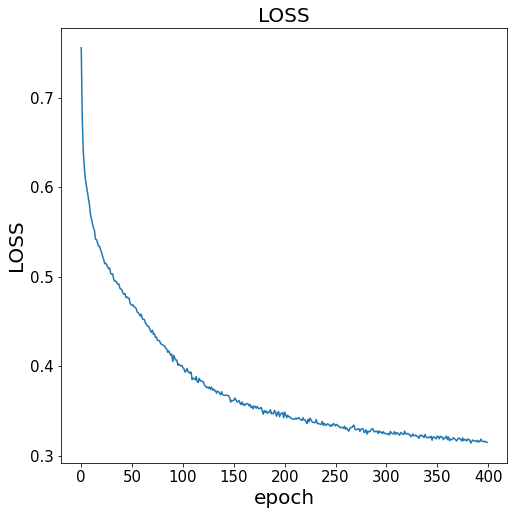

In [447]:
plt.figure(figsize=(8,8))
plt.plot(range(epochs),losses)
plt.title('LOSS', size = 20)
plt.xlabel('epoch', size = 20)
plt.ylabel('LOSS', size = 20)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.show()

In [448]:
with torch.no_grad():
    ypredTest = model3(cateXTestTensor,contXTestTensor)
    loss = criterion(ypredTest,yTestTensor)
loss = loss.item()
print(loss)   

0.4064699709415436


In [453]:
for i in range(20):
    pred = torch.argmax(ypredTest,dim =1)[i].item()
    real = yTestTensor[i].item()
    print(f"REAL CLASS: {real}, PREDICTED CLASS: {pred}")

REAL CLASS: 0, PREDICTED CLASS: 0
REAL CLASS: 0, PREDICTED CLASS: 0
REAL CLASS: 1, PREDICTED CLASS: 1
REAL CLASS: 1, PREDICTED CLASS: 1
REAL CLASS: 0, PREDICTED CLASS: 1
REAL CLASS: 0, PREDICTED CLASS: 0
REAL CLASS: 1, PREDICTED CLASS: 1
REAL CLASS: 0, PREDICTED CLASS: 1
REAL CLASS: 0, PREDICTED CLASS: 0
REAL CLASS: 0, PREDICTED CLASS: 0
REAL CLASS: 0, PREDICTED CLASS: 0
REAL CLASS: 0, PREDICTED CLASS: 0
REAL CLASS: 0, PREDICTED CLASS: 0
REAL CLASS: 0, PREDICTED CLASS: 0
REAL CLASS: 0, PREDICTED CLASS: 0
REAL CLASS: 1, PREDICTED CLASS: 1
REAL CLASS: 0, PREDICTED CLASS: 0
REAL CLASS: 0, PREDICTED CLASS: 0
REAL CLASS: 1, PREDICTED CLASS: 1
REAL CLASS: 0, PREDICTED CLASS: 0


In [456]:
from sklearn.metrics import confusion_matrix
confusion_matrix(yTestTensor.numpy(), torch.argmax(ypredTest,dim =1).numpy(), labels = [0,1])

array([[4096,  435],
       [ 618,  884]], dtype=int64)

In [459]:
from sklearn.metrics import classification_report
print(classification_report(yTestTensor.numpy(), torch.argmax(ypredTest,dim =1).numpy()))

              precision    recall  f1-score   support

           0       0.87      0.90      0.89      4531
           1       0.67      0.59      0.63      1502

    accuracy                           0.83      6033
   macro avg       0.77      0.75      0.76      6033
weighted avg       0.82      0.83      0.82      6033



* As expected, the model performs worst for the class underrepresented  